In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.mlab as mlab
from scipy.stats import norm

%matplotlib inline
import matplotlib.gridspec as gridspec
plt.rcParams['font.family']='serif'

In [3]:
###===========
# This section imports the necessary columns from the csv file into numpy arrays
###===========

csv = np.genfromtxt ('RadioDetectionTable_Limits.csv', delimiter=",")
LV = csv[1:,7]
LV_err = LV/10
LV=np.log10(LV) #convert to natural log basis
LV_err=np.log10(LV_err) #figure out why this isn't working
#y_err = csv[1:,8]
delta = csv[1:,10]
delta = delta.astype(int) #delta will index confirmed
delta = delta == 0
notdelta = np.logical_not(delta) #notdelta will index uplims

#Possible parameter-axes
spectype = csv[1:,2] 

t_eff = csv[1:,13]
tempsig = csv[1:,14]

vsini = csv[1:,3]
vsinisig = csv[1:,16]

#Dividing uplims by 3sigma and creating error bars for y-axis. 
#Separating out confirmed detections, and setting errors on uplims to average of confirmed error
LVconf = LV[delta]
LVconf_err = LVconf/10
# LVconf_err = LV_err[delta]
errav=np.mean(LVconf_err)

LVuplim = LV[notdelta]
LVuplim = LVuplim/3
LVuplim_err = np.full((1, (len(LVuplim))), errav)

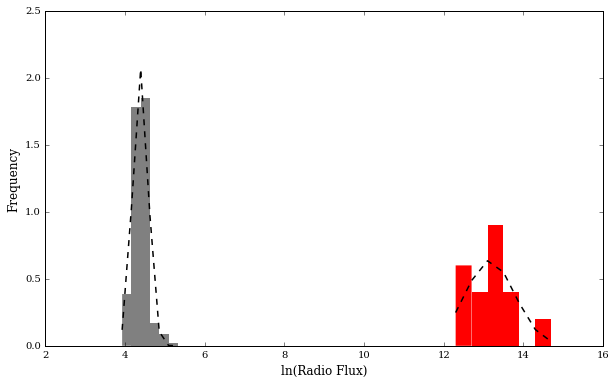

In [13]:
###===========
# This section plots histogram to extract Q prior
###===========

plt.figure(figsize=(10,6))

(mu, sigma) = norm.fit(LVconf) #mu is mean, sigma is width
n, bins, patches = plt.hist(LVconf, bins=6, normed=True, facecolor='red', edgecolor='none')
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=1.5)

(xi, delta) = norm.fit(LVuplim)
m, bins2, patches2 = plt.hist(LVuplim, bins=6, normed=True, facecolor='grey', edgecolor='none')
z = mlab.normpdf(bins2, xi, delta)
l = plt.plot(bins2, z, 'k--', linewidth=1.5)

plt.xlabel("ln(Radio Flux)", fontsize='12')
plt.ylabel("Frequency", fontsize='12')

In [ ]:
###===========
# This section plots likelihood function for simplest model
###===========

#Starting with Ploud
pi = math.pi
#the variance of the pquiet gaussian is delta^2
var_pquiet=delta**2
var_ploud=sigma**2
#LVtotal will be an array of all the measurements

Ploud = (1/np.sqrt(2*pi*var_pquiet))*np.exp(np.negative(1/2)*((y-LVtotal)/var_pquiet))

#Defining the Likelihood function
Q=10
var_tot = var_ploud*var_pquiet
m = (y/var_ploud + LVtotal/var_pquiet)*(1/var_ploud+1/var_pquiet)**np.negative(1)

#Need to figure out stepfunction for 1-Ploud
Likelihood = (1-Ploud)*np.piecewise(y, [y<Q, y>=Q], [1,0]) + (Ploud*((1/np.sqrt(2*pi*var_tot))*np.exp(np.negative(1/2)*((y-m)/var_tot))))
